# Behavioral analysis of the SAflow MEG dataset


In [12]:
import os
import os.path as op
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from saflow.behav import *
from saflow import LOGS_DIR
import pdb
import matplotlib.gridspec as gridspec
from scipy.stats import ks_2samp
from statannotations.stats.StatTest import StatTest
from statannotations.Annotator import Annotator
from saflow import SUBJ_LIST
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.autonotebook import tqdm


LOGS_DIR = "/media/hyruuk/Seagate Expansion Drive/saflow_DATA/behav/"
files_list = os.listdir(LOGS_DIR)
cpt_blocs = [2,3,4,5,6,7]





def full_behavior_plot(
    files_list,
    SUBJ_LIST,
    inout_bounds,
    filt_cutoff,
    BLOCS_LIST=[2, 3, 4, 5, 6, 7],
    stats="ks2samp",
    subject="32",
    bloc=2,
):
    if stats == "ks2samp":
        # Set stats
        custom_long_name = "Kolmogorov-Smirnov test for goodness of fit"
        custom_short_name = "Kolmogorov-Smirnov"
        custom_func = ks_2samp
        pairs = [(("IN", "OUT"))]
        custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

    # Get Subject VTC
    (
        IN_idx,
        OUT_idx,
        VTC_raw,
        VTC_filtered,
        IN_mask,
        OUT_mask,
        performance_dict,
        df_response,
        RT_to_VTC,
    ) = get_VTC_from_file(
        subject, bloc, files_list, inout_bounds=inout_bounds, filt_cutoff=filt_cutoff
    )
    plot_df = get_behavior_dict(files_list, SUBJ_LIST, BLOCS_LIST=BLOCS_LIST)

    # Start plotting
    fig = plt.figure(figsize=(20, 10))
    gs_outer = fig.add_gridspec(3, 4)
    subgrid_axes_vtc = fig.add_subplot(gs_outer[:2, :3])
    plot_VTC(
        VTC_filtered,
        VTC_raw,
        IN_mask,
        OUT_mask,
        performance_dict,
        subject_name=subject,
        bloc=bloc,
        subgrid_axes=subgrid_axes_vtc,
        fig=fig,
    )

    subgrid_ax_lapse_rate = fig.add_subplot(gs_outer[2, 0])
    subgrid_ax_omierr_rate = fig.add_subplot(gs_outer[2, 1])
    subgrid_ax_comerr = fig.add_subplot(gs_outer[2, 2])

    subgrid_ax_lapse_rate = sns.barplot(
        x="cond", y="lapse_rate", data=plot_df, ax=subgrid_ax_lapse_rate
    )
    annot = Annotator(
        subgrid_ax_lapse_rate, pairs, data=plot_df, x="cond", y="lapse_rate"
    )
    annot.configure(
        test=custom_test, comparisons_correction="fdr_bh", text_format="star"
    ).apply_test().annotate()

    subgrid_ax_omierr_rate = sns.barplot(
        x="cond", y="omission_error_rate", data=plot_df, ax=subgrid_ax_omierr_rate
    )
    annot = Annotator(
        subgrid_ax_omierr_rate, pairs, data=plot_df, x="cond", y="omission_error_rate"
    )
    annot.configure(
        test=custom_test, comparisons_correction="fdr_bh", text_format="star"
    ).apply_test().annotate()

    subgrid_ax_comerr = sns.barplot(
        x="cond", y="commission_error", data=plot_df, ax=subgrid_ax_comerr
    )
    annot = Annotator(
        subgrid_ax_comerr, pairs, data=plot_df, x="cond", y="commission_error"
    )
    annot.configure(
        test=custom_test, comparisons_correction="fdr_bh", text_format="star"
    ).apply_test().annotate()

    figtitle = (
        f" <{inout_bounds[0]} = IN; >{inout_bounds[1]} = OUT; f_cutoff = {filt_cutoff}"
    )
    fig.suptitle(figtitle, fontsize=16, y=0.94, x=0.42)
    fig.savefig(f"../reports/figures/behav_fullplot_{inout_bounds}_{filt_cutoff}.jpg")
    return fig

def get_behavior_dict(files_list, SUBJ_LIST, BLOCS_LIST=[2, 3, 4, 5, 6, 7]):
    # Get behaviour
    lapse_rates = []
    omission_error_rates = []
    n_rares_list = []
    bloc_list = []
    subject_list = []
    cond_list = []
    splitperf_dict = {
        "commission_error": [],
        "omission_error": [],
        "commission_correct": [],
        "omission_correct": [],
    }
    RT_preCE_list = []
    RT_preOC_list = []
    RT_preCC_list = []
    
    for subject in SUBJ_LIST:
        for bloc in BLOCS_LIST:
            (
                IN_idx,
                OUT_idx,
                VTC_raw,
                VTC_filtered,
                IN_mask,
                OUT_mask,
                performance_dict,
                df_response,
                RT_to_VTC,
            ) = get_VTC_from_file(
                subject,
                bloc,
                files_list,
                inout_bounds=inout_bounds,
                filt_cutoff=filt_cutoff,
            )
            for loop_idx, inout_idx in enumerate([IN_idx, OUT_idx]):
                # Split behavior into IN/OUT
                commission_error = [
                    x for x in performance_dict["commission_error"] if x in inout_idx
                ]
                omission_error = [
                    x for x in performance_dict["omission_error"] if x in inout_idx
                ]
                commission_correct = [
                    x for x in performance_dict["correct_commission"] if x in inout_idx
                ]
                omission_correct = [
                    x for x in performance_dict["correct_omission"] if x in inout_idx
                ]
                
                preCE = [x-1 for x in performance_dict["commission_error"] if x in inout_idx if x >> 0 if x-1 in performance_dict["correct_commission"]]
                preOC = [x-1 for x in performance_dict["correct_omission"] if x in inout_idx if x >> 0 if x-1 in performance_dict["correct_commission"]]
                preCC = [x-1 for x in performance_dict["correct_commission"] if x in inout_idx if x >> 0 if x-1 in performance_dict["correct_commission"]]
                RT_preCE = RT_to_VTC[preCE]
                RT_preOC = RT_to_VTC[preOC]
                RT_preCC = RT_to_VTC[preCC]

                # Compute rates
                try:
                    lapse_rate = len(commission_error) / (
                        len(omission_correct) + len(commission_error)
                    )
                except ZeroDivisionError:
                    lapse_rate = np.nan
                omission_error_rate = len(omission_error) / (
                    len(commission_correct) + len(omission_error)
                )

                # Pass to lists to pass to dict (sounds dumb ? it is)
                n_rares_list.append((len(omission_correct) + len(commission_error)))
                lapse_rates.append(lapse_rate)
                omission_error_rates.append(omission_error_rate)
                bloc_list.append(bloc)
                subject_list.append(subject)
                splitperf_dict["commission_error"].append(len(commission_error))
                splitperf_dict["omission_error"].append(len(omission_error))
                splitperf_dict["commission_correct"].append(len(commission_correct))
                splitperf_dict["omission_correct"].append(len(omission_correct))
                RT_preCE_list.append(np.nanmean(np.array(RT_preCE)))
                RT_preOC_list.append(np.nanmean(np.array(RT_preOC)))
                RT_preCC_list.append(np.nanmean(np.array(RT_preCC)))
                if loop_idx == 0:
                    cond_list.append("IN")
                else:
                    cond_list.append("OUT")

    plot_df = pd.DataFrame(
        {
            "lapse_rate": lapse_rates,
            "omission_error_rate": omission_error_rates,
            "commission_error": splitperf_dict["commission_error"],
            "omission_error": splitperf_dict["omission_error"],
            "commission_correct": splitperf_dict["commission_correct"],
            "omission_correct": splitperf_dict["omission_correct"],
            "RT_preCE":RT_preCE_list,
            "RT_preOC":RT_preOC_list,
            "RT_preCC":RT_preCC_list,
            "n_rare": n_rares_list,
            "subject": subject_list,
            "bloc": bloc_list,
            "cond": cond_list,
        }
    )
    return plot_df

/tmp/ipykernel_201573/2624392677.py:201: RuntimeWarning: Mean of empty slice
  RT_preOE_list.append(np.nanmean(np.array(RT_preOE)))
/tmp/ipykernel_201573/2624392677.py:200: RuntimeWarning: Mean of empty slice
  RT_preCE_list.append(np.nanmean(np.array(RT_preCE)))


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:7.606e-07 Stat=2.760e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:1.459e-18 Stat=4.583e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:4.520e-12 Stat=3.698e-01


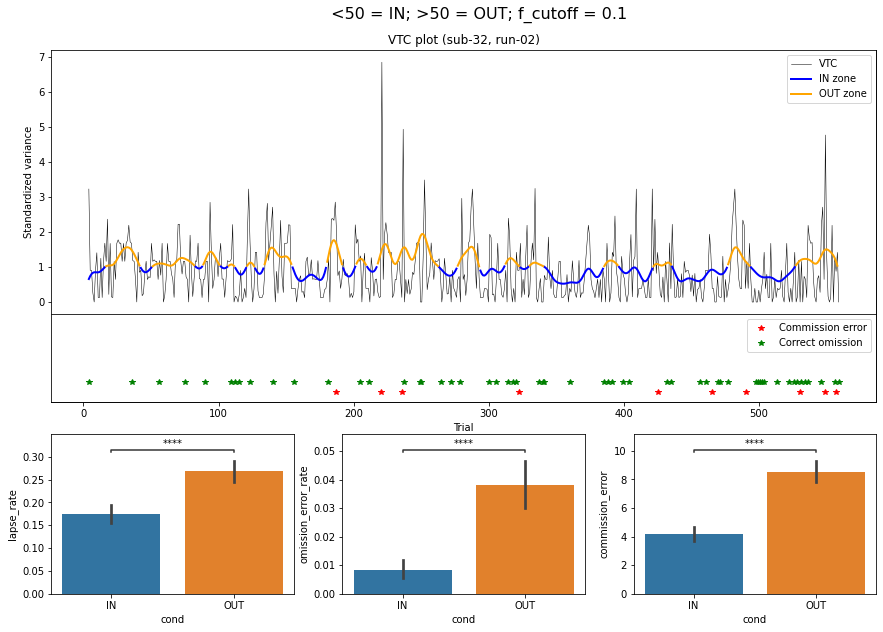

In [2]:
# Bigass behavioral plot

subject = '32'
bloc = 2
inout_bounds = [50,50]
filt_cutoff = 0.1

full_behavior_plot(files_list, SUBJ_LIST, inout_bounds, filt_cutoff, stats='ks2samp', subject=subject, bloc=bloc);

In [ ]:
!pip install statannotations

In [ ]:
# Simple plot
subject = '07'
bloc = 3
inout_bounds = [50,50]
filt_cutoff = 0.1


IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response = get_VTC_from_file(subject, bloc, files_list, 
                                                                                                             inout_bounds=inout_bounds, 
                                                                                                             filt_cutoff=filt_cutoff)
plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask, performance_dict, subject_name=subject, bloc=bloc);

In [ ]:
# Subject-wise plots

IMG_DIR = '/home/hyruuk/GitHub/cc_saflow/reports/figures/VTC_plots/'
os.makedirs(IMG_DIR, exist_ok=True)

for subject in SUBJ_LIST:
    fig = subject_plot_VTC(subject)
    fig_name = f'sub-{subject}_VTC_plots.jpg'
    fig.savefig(op.join(IMG_DIR, fig_name))
    plt.close()



/tmp/ipykernel_201573/37649173.py:200: RuntimeWarning: Mean of empty slice
  RT_preCE_list.append(np.nanmean(np.array(RT_preCE)))


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:3.954e-24 Stat=5.208e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:7.606e-07 Stat=2.760e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IN vs. OUT: Kolmogorov-Smirnov test for goodness of fit with Benjamini-Hochberg correction, P_val:1.459e-18 Stat=4.583e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
  

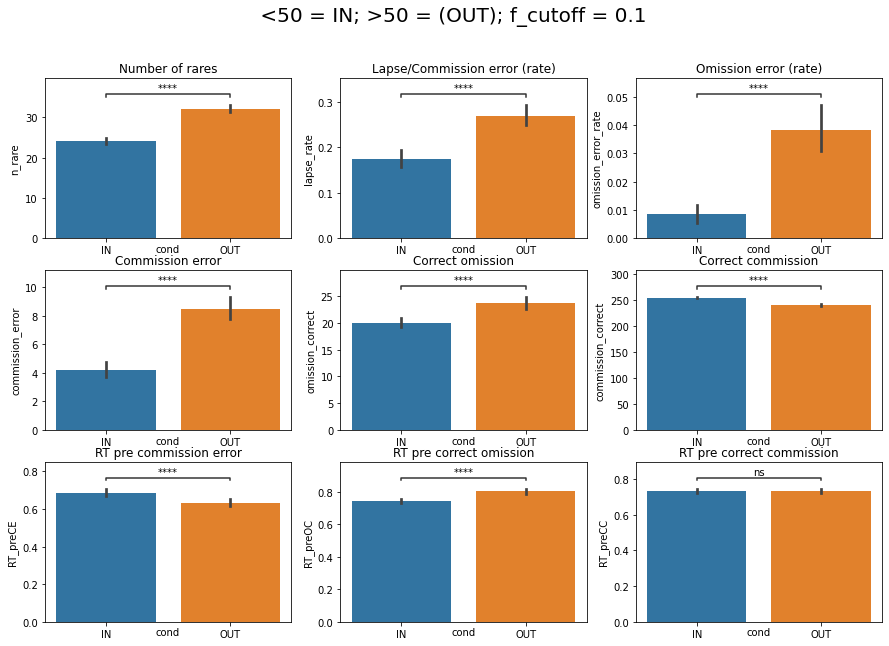

In [13]:
# Performance figures
def performance_plots(
    files_list, SUBJ_LIST, BLOCS_LIST, inout_bounds, filt_cutoff, stats="ks2samp"
):
    # Set stats
    if stats == "ks2samp":
        custom_long_name = "Kolmogorov-Smirnov test for goodness of fit"
        custom_short_name = "Kolmogorov-Smirnov"
        custom_func = ks_2samp
        pairs = [(("IN", "OUT"))]
        custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

    plot_df = get_behavior_dict(files_list, SUBJ_LIST, BLOCS_LIST=BLOCS_LIST)

    # Set variables to plot
    variables = [
        "n_rare",
        "lapse_rate",
        "omission_error_rate",
        "commission_error",
        "omission_correct",
        "commission_correct",
        "RT_preCE",
        "RT_preOC",
        "RT_preCC",
        
    ]
    variables_names = [
        "Number of rares",
        "Lapse/Commission error (rate)",
        "Omission error (rate)",
        "Commission error",
        "Correct omission",
        "Correct commission",
        "RT pre commission error",
        "RT pre correct omission",
        "RT pre correct commission",
    ]

    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    figtitle = f" <{inout_bounds[0]} = IN; >{inout_bounds[1]} = (OUT); f_cutoff = {filt_cutoff}"
    fig.suptitle(figtitle, fontsize=20)
    for idx, ax in enumerate(axes.flat):
        variable = variables[idx]
        ax = sns.barplot(x="cond", y=variable, data=plot_df, ax=ax)
        ax.set_title(f"{variables_names[idx]}")
        ax.xaxis.set_label_coords(0.5, -0.035)
        annot = Annotator(ax, pairs, data=plot_df, x="cond", y=variable)
        annot.configure(
            test=custom_test, comparisons_correction="fdr_bh", text_format="star"
        ).apply_test().annotate()

    fig.savefig(f"../reports/figures/behav_barplots_{inout_bounds}_{filt_cutoff}.png")
    return fig



inout_bounds = [50,50]
filt_cutoff = 0.1    

performance_plots(files_list, SUBJ_LIST, [2,3,4,5,6,7], inout_bounds, filt_cutoff, stats='ks2samp');

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(1,1,1)
ax = sns.barplot(x="subject", hue='cond', y="n_rare", data=plot_df, ax=ax)

In [ ]:
# Look at distributions of filtered VTC values

In [ ]:
# Check Bastien Sackur for markov chains - mind wandering

In [ ]:
# Just check the first three runs of each subject

In [ ]:
# Try removing trials surrounding Commission Errors